In [1]:
import os, time, copy
from collections import OrderedDict
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as vmodels
import torchvision.datasets as vdatasets

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as patches
import matplotlib.font_manager as fm
path = '/Library/Fonts/NanumBarunGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

from PIL import Image as pil_image

import numpy as np
from skimage.transform import resize
from skimage.measure import label, regionprops

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Resnet_fc(nn.Module):
    def __init__(self, base_model, nb_classes):
        super(Resnet_fc, self).__init__()

        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        tmp = OrderedDict()
        tmp['last_conv'] = nn.Conv2d(2048, nb_classes, 1, 1)
        tmp['gap'] = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

        self.classifier_layer = nn.Sequential(tmp)

    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        x = self.classifier_layer(features)
        return x, features

In [5]:
base_model = vmodels.resnet50(pretrained=False)
net = Resnet_fc(base_model, 5)
net.load_state_dict(torch.load("../weights/pred_fullyconv/acolbase_e13.pth.tar", map_location='cpu'))
# net.load_state_dict(torch.load("../weights/pred_fullyconv/best_model_e16_val_acc0.95.pth.tar", map_location='cpu'))
net.eval()
net.to(device)


Resnet_fc(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64

In [6]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
cls2name = {0: '안철수', 1: '홍준표', 2:'문재인', 3:'심상정', 4:'유승민'}
cls2color = {0: 'green', 1: 'red', 2:'blue', 3:'yellow', 4:'teal'}

In [96]:
img_path = 'samples/all.jpg'

In [97]:
img = pil_image.open(img_path)
img_array = np.asarray(img)[:, :, :3]
n_H, n_W, n_C = img_array.shape

to_feed = copy.deepcopy(img_array)
inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
inp_tensor = inp_tensor.to(device)

output, features = net(inp_tensor)
softmax_output = F.softmax(output, dim=1)

0
15
max: 0.969
min: 0.570
mean: 0.799


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


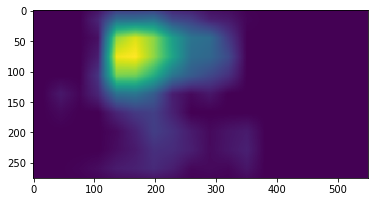

1
1
max: 0.600
min: 0.600
mean: 0.600


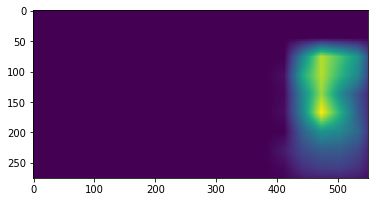

2
3
max: 0.814
min: 0.530
mean: 0.697


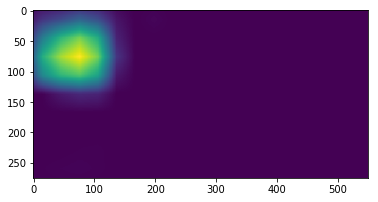

3
1
max: 0.418
min: 0.418
mean: 0.418


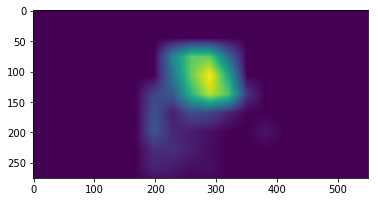

4
15
max: 0.955
min: 0.424
mean: 0.726


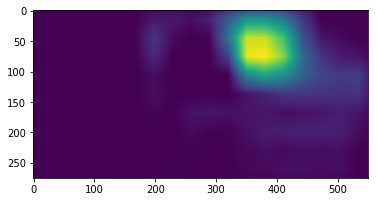

In [103]:
for cls in [0, 1, 2, 3, 4]:
    print(cls)


    s_1, s_2 = features.size()[2:]

    sl_1 = s_1-7+1
    sl_2 = s_2-7+1

    W_conv = net.classifier_layer.last_conv.weight.detach()
    W_conv_c = W_conv[cls]

    probs = []

    A_conv_c = torch.zeros(1, s_1, s_2)
    for i in range(sl_1):
        for j in range(sl_2):

            target_softmax = softmax_output[0][cls,i,j]

            max_cls = torch.argmax(softmax_output[0][:,i,j]).item()
            if cls == max_cls:

                if target_softmax > 0.4:
                    probs.append(target_softmax.item())

                    a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
                    A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
                    
    _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
    _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
    A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
    canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))
    print(len(probs))
    print("max: {:.3f}".format(max(probs)))
    print("min: {:.3f}".format(min(probs)))
    print("mean: {:.3f}".format(np.mean(probs)))
    
    plt.imshow(canvas)
    plt.show()

In [92]:
def run_inference(img_path, is_heatmap, save=False, save_dir=None):
    img = pil_image.open(img_path)
    img_array = np.asarray(img)[:, :, :3]
    n_H, n_W, n_C = img_array.shape
    
    to_feed = copy.deepcopy(img_array)
    inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
    inp_tensor = inp_tensor.to(device)
    
    output, features = net(inp_tensor)
    softmax_output = F.softmax(output, dim=1)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_array)
    ax.axis("off")
    
        
    for cls in [0, 1, 2, 3, 4]:
        print(cls)
        

        s_1, s_2 = features.size()[2:]

        sl_1 = s_1-7+1
        sl_2 = s_2-7+1

        W_conv = net.classifier_layer.last_conv.weight.detach()
        W_conv_c = W_conv[cls]
        
        probs = []

        A_conv_c = torch.zeros(1, s_1, s_2)
        for i in range(sl_1):
            for j in range(sl_2):
                
                target_softmax = softmax_output[0][cls,i,j]
                
                max_cls = torch.argmax(softmax_output[0][:,i,j]).item()
                if cls == max_cls:

                    if target_softmax > 0.5:
                        probs.append(target_softmax.item())
                
                        a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
                        A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
        _min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
        _max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
        A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)
        canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))
        if len(probs) < 1:
            mean_prob = 0
        else:
            mean_prob = np.max(probs)
        
        if mean_prob > 0.9:
            canvas = resize(A_conv_c_normalized[0].detach().cpu().numpy(), (n_H, n_W))
        else:
            canvas = resize(torch.zeros(A_conv_c.size()).detach().cpu().numpy(), (n_H, n_W))

        if is_heatmap:
            ax.imshow(canvas, cmap='jet', alpha=0.5)
        else:
            labeled = label(canvas > 0.3)
            props = regionprops(labeled)

            rects = []
            for p in props:
                ys, xs, ye, xe = p.bbox
                w = xe - xs
                h = ye - ys

                if w * h > 3000:
                    print(w, h)

                    rect = patches.Rectangle((xs, ys), w, h, linewidth=3, edgecolor=cls2color[cls], facecolor='none', alpha=0.75)
                    rects.append(rect)
                    ax.text(x=xs + 5, y=ys + 23, s=cls2name[cls] + '{:.3f}'.format(mean_prob), fontproperties=fontprop, color=cls2color[cls])

            for r in rects:
                ax.add_patch(r)
                    
    
    if save:
        fname = os.path.basename(img_path)
        full_path = os.path.join(save_dir, fname)
        fig.savefig(full_path, bbox_inches='tight')
        print("saved - {}".format(full_path))
    else:
        plt.show()

0


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


1
149 292
2
129 107
3
4
209 302


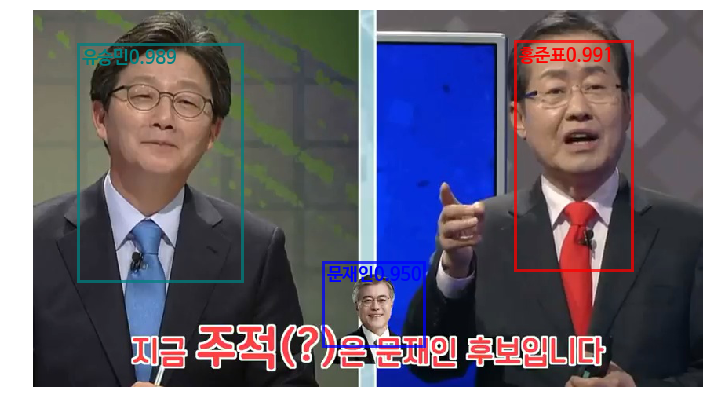

In [93]:
# run_inference("samples/moon3.jpg", is_heatmap=False, save=False, save_dir='video_res')
run_inference("../datasets/presidential_debate_frames_v2/frame040.jpg", is_heatmap=False, save=False, save_dir=None)

In [94]:
paths = glob("samples/*.jpg")

0
100 95
189 162
1


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


2
3
4


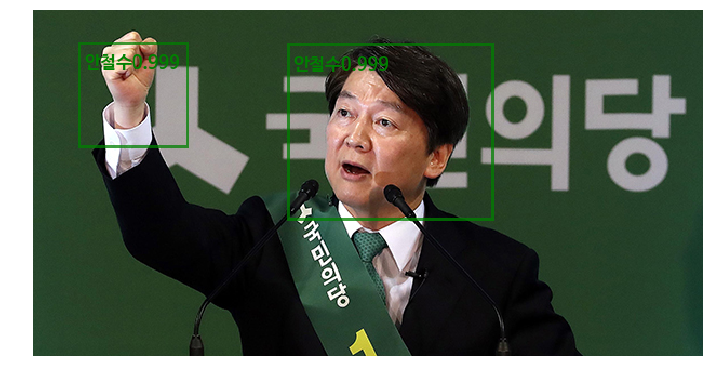

0
1
2
3
4


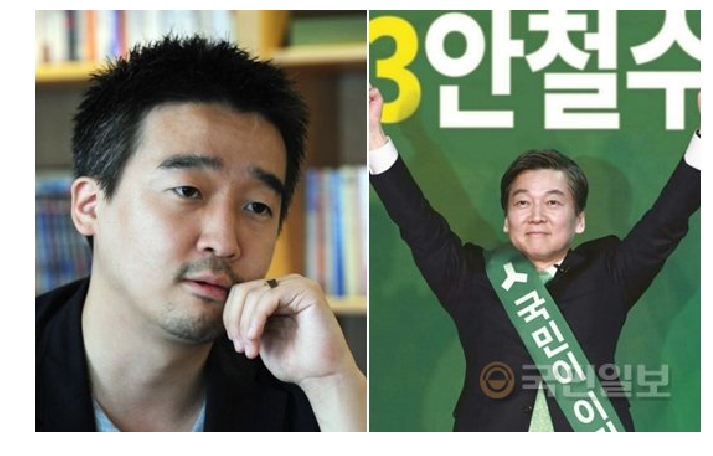

0
161 161
1
2
3
4


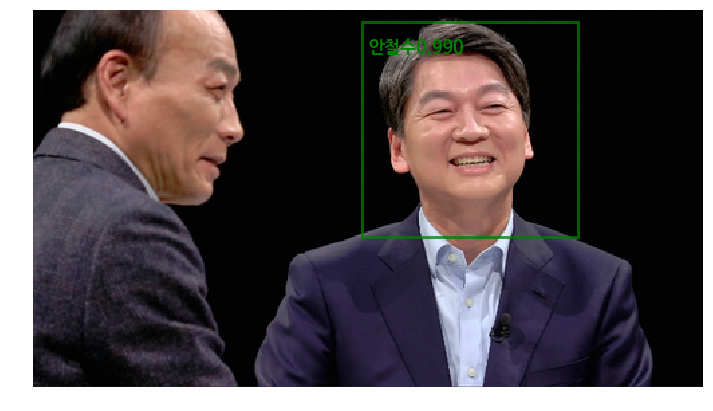

0
185 140
1
2
3
4
135 122


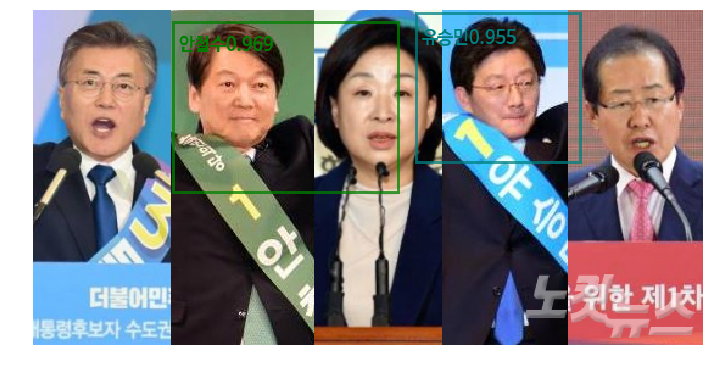

0
1
2
3
4
127 126
58 59


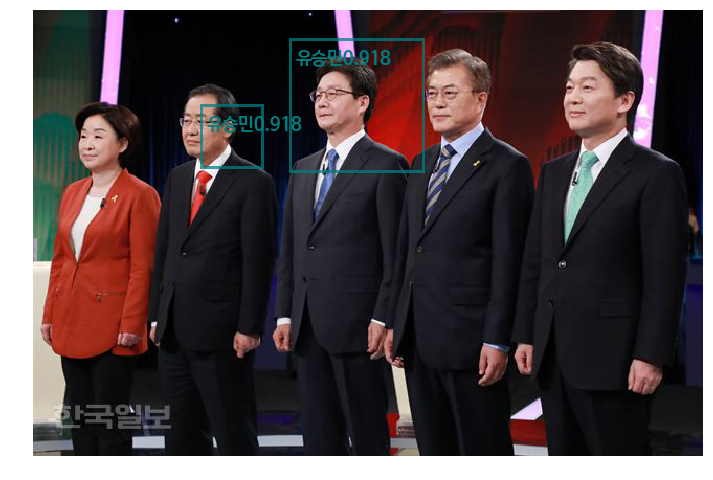

0
1
2
371 143
133 117
3
4


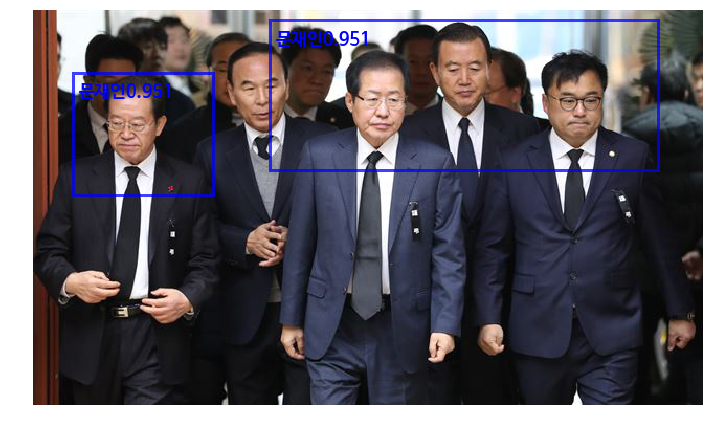

0
1
153 263
2
3
4


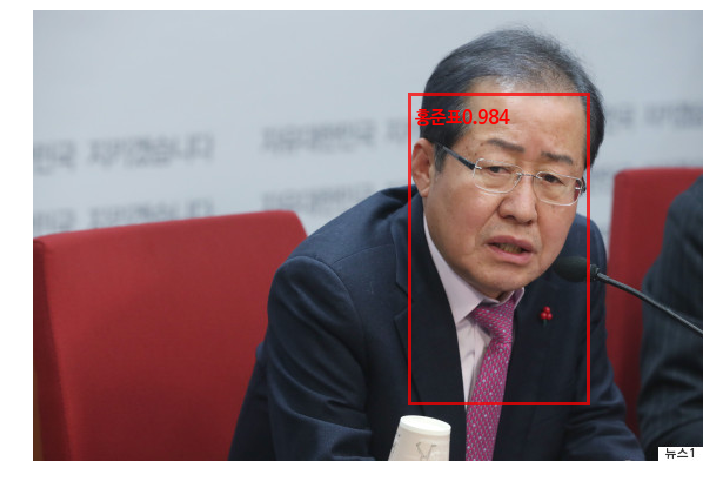

0
1
144 198
2
3
4


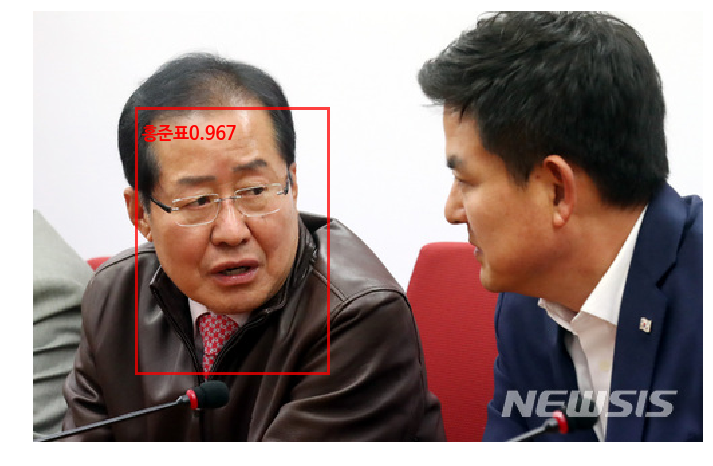

0
1
2
127 111
3
4


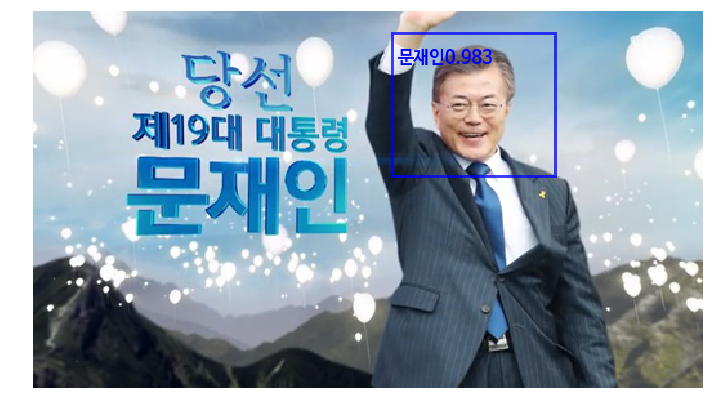

0
1
2
139 117
3
4


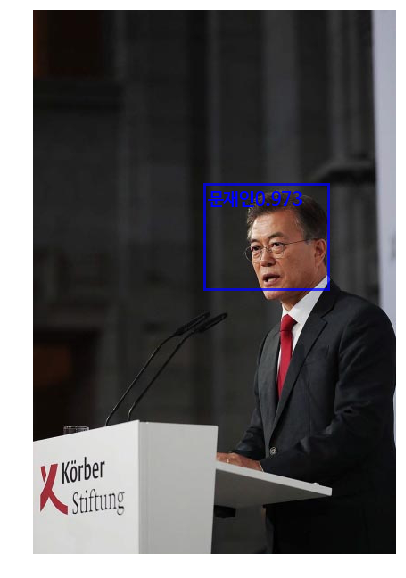

0
1
2
3
616 271
4


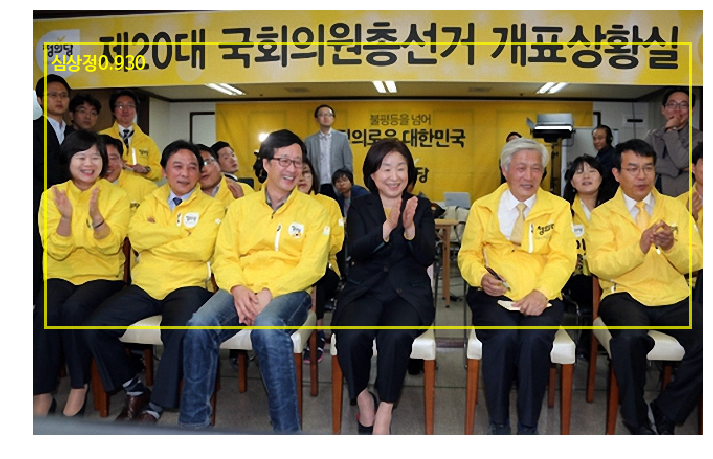

0
1
2
3
210 184
4


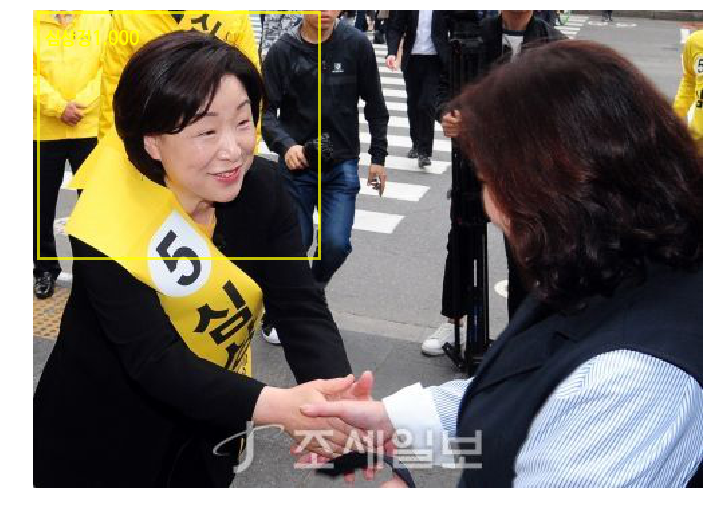

0
1
2
3
172 159
253 130
4


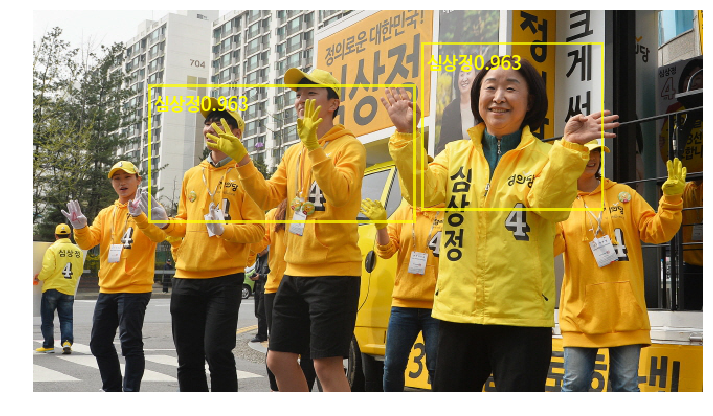

0
1
2
3
4


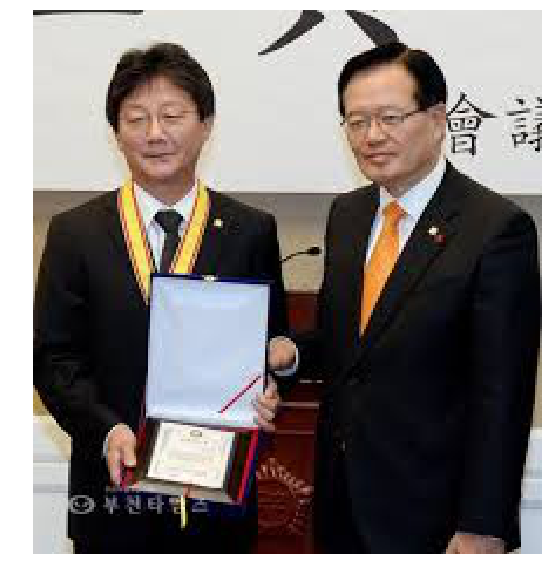

0
1
2
3
4
172 223


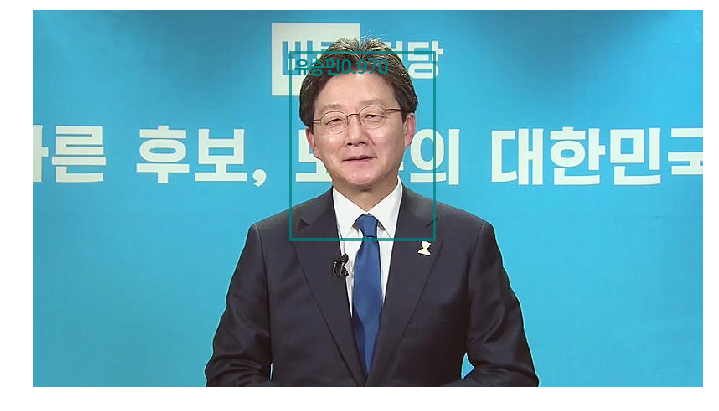

0
148 216
1
2
3
4
152 164


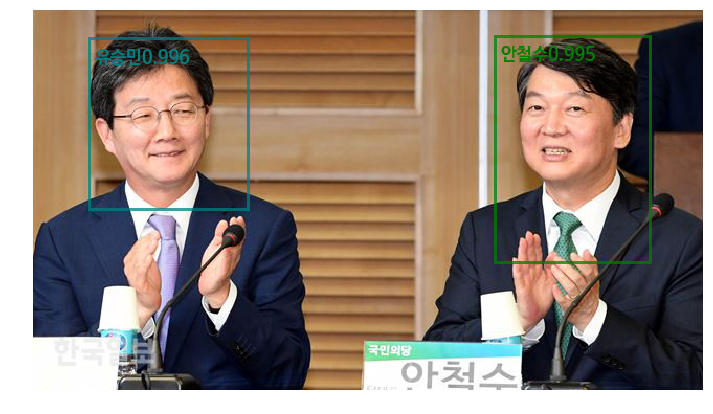

In [95]:
for p in paths:
    run_inference(p, is_heatmap=False, save=False, save_dir=None)